In [14]:
import os, time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import dgl
import dgl.function as fn
import pickle as pkl
import torch
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve

In [15]:
from xgnn_src.shared_networks import MLP, MLP_PRED
from xgnn_src.node.online_kg2 import AllOnlineKG
import torch.nn.functional as F

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8, 8]

In [17]:
from utils import *
from xgnn_src.node.eval import *

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [19]:
from xgnn_src.node.eval import predict, evaluate_dataset, extract_true_motif, explain_test
from xgnn_src.node.draw import draw_simple_graph

In [20]:
Arg = collections.namedtuple("Arg", ["teacher_name", "hidden_sizes", "n_layers", "dropout", "n_hidden", "all_layer_dp", "skip_norm"])

- Nodes of label 0 belong to the base BA graph
- Nodes of label 1, 2, 3 are separately at the middle, bottom, or top of houses

### Using bidirected graph (default)

In [21]:
kl = "01"
# ba_shape1.g, ba_shape.pt
with open('./datasets/tree_cycle_bidir.g', 'rb') as f:
    g = pkl.load(f)

num_classes = 2
test_labels = g.ndata['label'][g.ndata['test_mask']]
feats = g.ndata['feat'].size()[1]
arg = Arg("gcn2", [64], 5, 0.5, 64, True, True)
base = init_teacher(arg, g, feats, num_classes)
graph_std = init_graph_student("gcn", g, feats, num_classes, 0.5, n_hidden=64,
                                n_layers=5, hidden_sizes=None, all_layer_dp=True, skip_norm=True)
mlp = MLP(feats, [64], num_classes, F.relu, 0.5, batch_norm=True, norm_type='bn')
online_mode = AllOnlineKG(base, graph_std, mlp, graph_student_name="gcn")
model = torch.load('./ckpt/gcn/tree_circles_feat_bidir_kl%s.pt'%kl, map_location="cpu")
online_mode.load_state_dict(model)

using norm in graph False
GCN2(
  (layers): ModuleList(
    (0): GraphConv(in=3, out=64, normalization=both, activation=None)
    (1): GraphConv(in=64, out=64, normalization=both, activation=None)
    (2): GraphConv(in=64, out=64, normalization=both, activation=None)
    (3): GraphConv(in=64, out=64, normalization=both, activation=None)
    (4): GraphConv(in=64, out=64, normalization=both, activation=None)
    (5): GraphConv(in=64, out=2, normalization=both, activation=None)
  )
  (batch_norms): ModuleList()
  (dropout): Dropout(p=0.5, inplace=False)
)
using norm in graph False
norm type: bn
norm type: bn
norm type: bn


<All keys matched successfully>

In [9]:
b_preds, e_preds = predict(base, graph_std, g)

Base accuracy: 1.0000, Explainer accuracy: 0.9885
Agreement score: 0.9885, KL Score: 0.0018


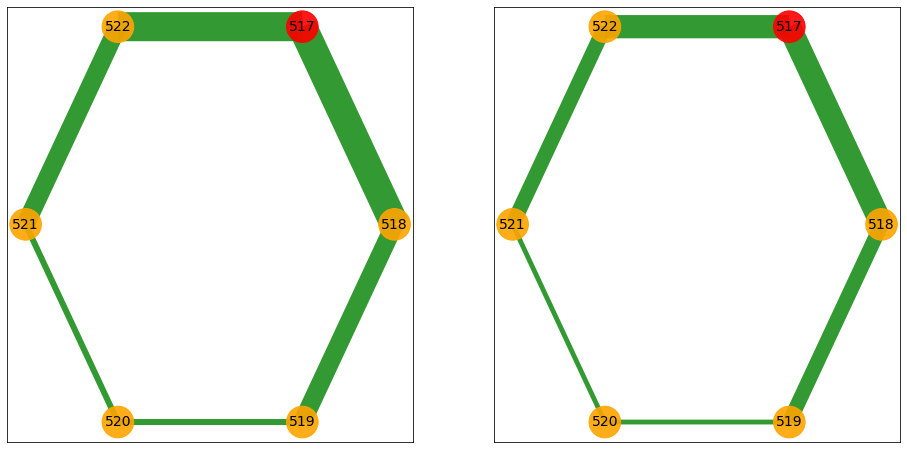

In [10]:
plt.rcParams["figure.figsize"] = [16, 8]
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()
ng1 = explain_test(g, 517, 6, ax=ax[0], undir=True, scale=25, dumping_factor=0.5, num_iter=10)
# ax[0].set_axis_off()
# 103, 276, 289
ng2 = explain_test(g, 517, 6, ax=ax[1], undir=True, scale=20, dumping_factor=0.5)
# ax[1].set_axis_off()
# plt.savefig('./images/ba_shape.svg', format="svg", dpi=300)

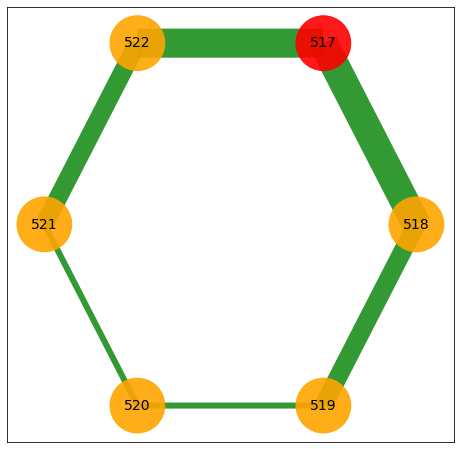

In [16]:
explain_test(g, 517, 6, undir=True, scale=25, dumping_factor=0.5, node_size=3000, margin=0.1)
plt.savefig('./images/tree_cycle_517.pdf', format="pdf", dpi=300)

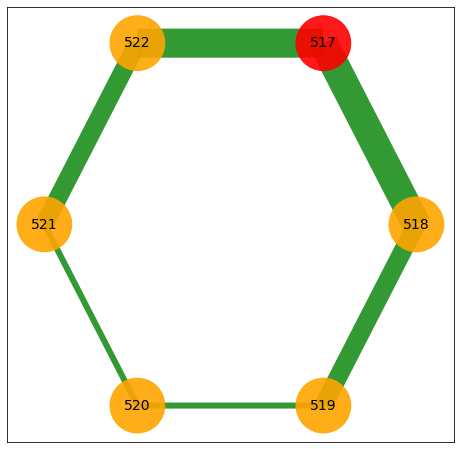

In [39]:
plt.rcParams['figure.figsize'] = [8,8]
explain_test(g, 517, 6, undir=True, scale=25, dumping_factor=0.5, node_size=3000, margin=0.1)
plt.savefig('./images/tree_cycle_517_l3.pdf', format="pdf", dpi=300)

In [22]:
selected_node = list(range(511,871,6))
test_pentagon = [extract_true_motif(g, i, 510, 6) for i in selected_node]

In [31]:
s = time.time()
all_pre, all_rec, _ = evaluate_dataset(g, selected_node, test_pentagon, 6, 10, dumping_factor=0.55, num_iter=10)
print("Test for tree circles - Precision: %.4f & Recall: %.4f F1 Score: %.4f"
          % (all_pre, all_rec, (all_pre*all_rec*2/(all_pre+all_rec))))
print(time.time() - s)

60it [00:02, 27.73it/s]

Test for tree circles - Precision: 0.9917 & Recall: 1.0000 F1 Score: 0.9959
2.1711626052856445


***Ground-truth***

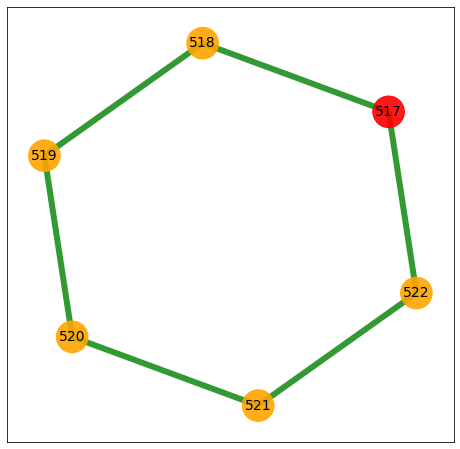

In [29]:
g = test_pentagon[1]
nodes = g.ndata['_ID']
labels = {k.item(): v.item() for k, v in zip(g.nodes(), nodes)}
draw_simple_graph(g, [3] * g.num_edges(), True, labels=labels, node_id=517, margin=0.1)
plt.savefig('./images/tree_cycle_517_real.pdf', format="pdf", dpi=300)

## TREE GRID

In [26]:
with open('./datasets/tree_grid_bidir.g', 'rb') as f:
    g1 = pkl.load(f)
#     g1 = g1.add_self_loop()
num_classes = 2
test_labels1 = g1.ndata['label'][g1.ndata['test_mask']]
feats1 = g1.ndata['feat'].size()[1]
arg1 = Arg("gcn2", [64], 5, 0.5, 64, True, True)
base1 = init_teacher(arg1, g1, feats1, num_classes)
graph_std1 = init_graph_student("gcn", g1, feats1, num_classes, 0.5, n_hidden=64,
                                n_layers=5, hidden_sizes=None, all_layer_dp=True, skip_norm=True)
mlp1 = MLP(feats1, [64], num_classes, F.relu, 0.5, batch_norm=True, norm_type='bn')
online_mode1 = AllOnlineKG(base1, graph_std1, mlp1, graph_student_name="gcn")
model1 = torch.load('./ckpt/gcn/tree_grid_feat_bidir_kl01.pt', map_location="cpu")
online_mode1.load_state_dict(model1)

using norm in graph False
GCN2(
  (layers): ModuleList(
    (0): GraphConv(in=3, out=64, normalization=both, activation=None)
    (1): GraphConv(in=64, out=64, normalization=both, activation=None)
    (2): GraphConv(in=64, out=64, normalization=both, activation=None)
    (3): GraphConv(in=64, out=64, normalization=both, activation=None)
    (4): GraphConv(in=64, out=64, normalization=both, activation=None)
    (5): GraphConv(in=64, out=2, normalization=both, activation=None)
  )
  (batch_norms): ModuleList()
  (dropout): Dropout(p=0.5, inplace=False)
)
using norm in graph False
norm type: bn
norm type: bn
norm type: bn


<All keys matched successfully>

In [11]:
b, e = predict(base1, graph_std1, g1)

Base accuracy: 0.9593, Explainer accuracy: 0.9431
Agreement score: 0.9675, KL Score: 0.0022


torch.return_types.topk(
values=tensor([653.7269, 153.9991, 153.9991,  77.4810,  40.2763,  28.3275,  28.3275]),
indices=tensor([511, 512, 514, 515,   0, 517, 513]))
torch.return_types.topk(
values=tensor([672.5818, 174.2604, 119.4849,  71.6363,  64.6314,  34.9768,  30.9618]),
indices=tensor([512, 515, 513, 511, 516, 514, 518]))


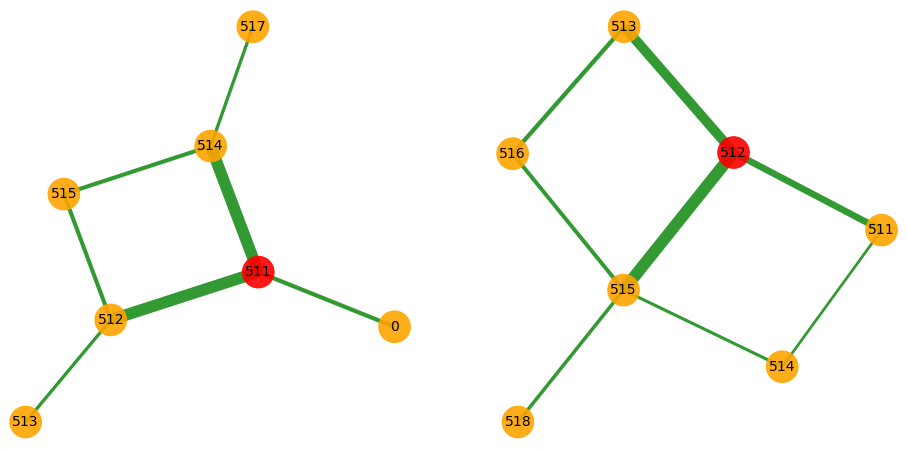

In [33]:
top_k = 7
hse = False
plt.rcParams["figure.figsize"] = [16, 8]
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = axes.flatten()
explain_test(g1, 511, top_k, ax=ax[0], scale=10, dumping_factor=0.5, num_iter=5, has_self_edge=hse)
ax[0].set_axis_off()
explain_test(g1, 512, top_k, ax=ax[1], scale=10, dumping_factor=0.5, num_iter=5)
ax[1].set_axis_off()
# plt.savefig('./images/ba_community.svg', format="svg", dpi=300)

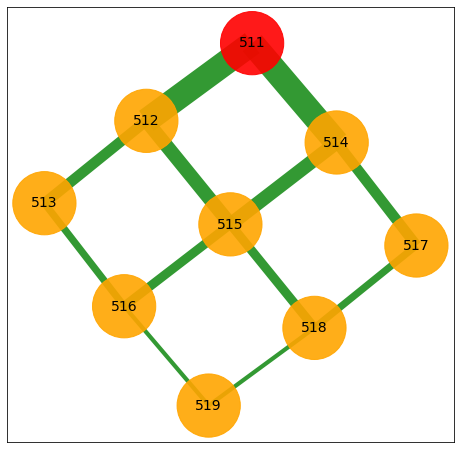

In [28]:
top_k = 10
plt.rcParams["figure.figsize"] = [8, 8]
explain_test(g1, 511, top_k, scale=20, num_iter=5,  node_size=4000, margin=0.1)
plt.savefig('./images/tree_grid_511.pdf', format="pdf", dpi=300)

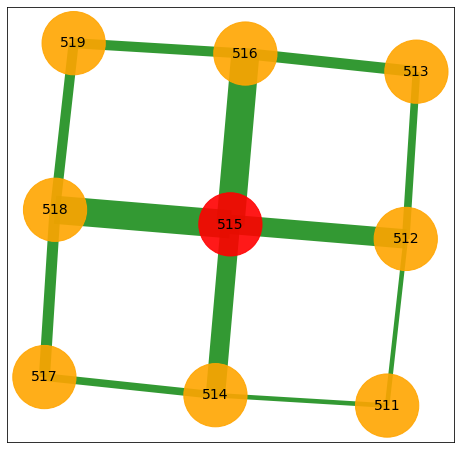

In [28]:
plt.rcParams["figure.figsize"] = [8, 8]
top_k = 9
explain_test(g1, 515, top_k, scale=20, num_iter=5, node_size=4000, margin=0.1)
plt.savefig('./images/tree_grid_515_l3.pdf', format="pdf", dpi=300)

In [12]:
selected = list(range(511,800,1))
test_graphs = [extract_true_motif(g1, i, 510, 9) for i in selected]

In [13]:
t = time.time()
all_pre, all_rec, _ = evaluate_dataset(g1, selected, test_graphs, 10, 12, dumping_factor=0.9, num_iter=5)
print("Test for tree grid - Precision: %.4f & Recall: %.4f F1: %.4f"
      % (all_pre, all_rec, (2*all_pre*all_rec/(all_pre+all_rec))))
e = time.time()
print(e - t)

289it [00:05, 49.90it/s]


Test for tree grid - Precision: 0.9716 & Recall: 0.9178 F1: 0.9440
5.813206434249878


***Ground truth***

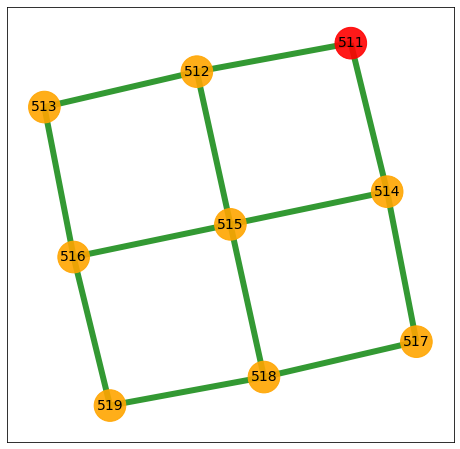

In [28]:
g = test_graphs[0]
nodes = g.ndata['_ID']
labels = {k.item(): v.item() for k, v in zip(g.nodes(), nodes)}
draw_simple_graph(g, [3] * g.num_edges(), True, labels=labels, node_id=511, margin=0.1)
plt.savefig('./images/tree_grid_511_real.pdf', format="pdf", dpi=300)